# Optimal Control of a planar 3R manipulator

**Loading the model of a manipulator from URDF file**

In [ ]:
!pip3 install crocoddyl meshcat
import os
import pinocchio
import crocoddyl
import numpy as np
import matplotlib.pyplot as plt

# Get the path to the urdf
urdf_model_path = os.path.abspath("3r.urdf")

# Load the model (using pinocchio)
robot = pinocchio.robot_wrapper.RobotWrapper.BuildFromURDF(urdf_model_path)
robot_model = robot.model        

**Function for calculating Inverse Kinematics**

In [215]:
def IK(x_e, y_e, phi):
    l1 = l2 = l3 = 1.0    
    x3 = x_e - l3 * np.cos(np.radians(phi))
    y3 = y_e - l3 * np.sin(np.radians(phi))

    th2 = np.arccos((x3**2 + y3**2 - (l1**2 + l2**2)) / (2 * l1 * l2))
    th1 = np.arctan2(y3, x3) - np.arctan2(l2 * np.sin(th2), l1 + l2 * np.cos(th2))
    th3 = np.radians(phi) - (th1 + th2)
    
    return np.array([th1, th2, th3]).T

**Setting parameters**

In [216]:
# initial position P[x, y, phi], where |x|≤3.0 [m], 0≤y≤3.0 [m], phi ∈ [-180, 180] 
P = [0.4, 1.625, 165]

# target point Z[x, y], where |x|<=3.0 [m],  0≤y≤3.0 [m]
Z = [2.1, 1.8]

# time T [s]
T = 1.0
DT = 1e-3  # time step [s]
K = int(T / DT)  # number of knots

# torque limits = {joint1, joint2, joint3} [Nm] 
robot_model.effortLimit = np.array([100, 100, 100])

**Building Running and Terminal Action models**

In [217]:
# Create data structures
robot_data = robot_model.createData()
state = crocoddyl.StateMultibody(robot.model)
actuationModel = crocoddyl.ActuationModelFull(state)

# Create cost models
runningCostModel = crocoddyl.CostModelSum(state)
terminalCostModel = crocoddyl.CostModelSum(state)

# Add a goal-tracking cost
target = np.array([Z[0], 0, Z[1]])      # Desired position
goalResidual = crocoddyl.ResidualModelFrameTranslation(state, robot_model.getFrameId("end_effector"), target)
goalTrackingCost = crocoddyl.CostModelResidual(state, goalResidual)
runningCostModel.addCost("gripperPose_cost", goalTrackingCost, 1)
terminalCostModel.addCost("gripperPose_cost", goalTrackingCost, 1e3)

# Add a cost on state (joint angles and velocities)
stateResidual = crocoddyl.ResidualModelState(state)
stateCost = crocoddyl.CostModelResidual(state, stateResidual)
runningCostModel.addCost("state_cost", stateCost, 5e-2)
terminalCostModel.addCost("state_cost", stateCost, 5e-2)

# Add a cost on control
controlResidual = crocoddyl.ResidualModelControl(state)
bounds = crocoddyl.ActivationBounds(-robot_model.effortLimit, robot_model.effortLimit)
activation = crocoddyl.ActivationModelQuadraticBarrier(bounds)
controlCost = crocoddyl.CostModelResidual(state, activation=activation, residual=controlResidual)
runningCostModel.addCost("control_cost", cost=controlCost, weight=5e-3)
terminalCostModel.addCost("control_cost", cost=controlCost, weight=5e-3)

# Create the action models for the state
runningModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(
        state, actuationModel, runningCostModel
    ),
    DT,
)

terminalModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(
        state, actuationModel, terminalCostModel
    )
)

**Defining the Shooting problem**

In [218]:
q0 = IK(P[0], P[1], P[2])           # Initial joint configurations
v0 = pinocchio.utils.zero(state.nv) # Initial joint velocities
x0 = np.concatenate([q0, v0])       # Inital robot state

problem = crocoddyl.ShootingProblem(x0, [runningModel] * K, terminalModel)

**Solving Optimal Control problem with DDP**

In [219]:
# Create a DDP solver 
solver = crocoddyl.SolverDDP(problem)

# Set callbacks for analysing the performance of the solver 
solver.setCallbacks(
    [
        crocoddyl.CallbackLogger(),
        crocoddyl.CallbackVerbose(),
    ]
)
solver.solve()

iter    cost       merit      stop       grad       preg       dreg      step   ||ffeas||  ||gfeas||  ||hfeas||   dV-exp       dV      dPhi-exp     dPhi
   0  1.290e+02  0.000e+00  1.619e+03  3.237e+03  1.000e-09  1.000e-09  1.0000  1.833e+00  0.000e+00  0.000e+00  1.619e+03  1.894e+03  0.000e+00  0.000e+00
   1  3.389e+01  0.000e+00  1.287e+02  2.574e+02  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  1.287e+02  9.515e+01  0.000e+00  0.000e+00
   2  1.476e+01  0.000e+00  3.358e+01  6.716e+01  1.000e-09  1.000e-09  0.5000  0.000e+00  0.000e+00  0.000e+00  2.519e+01  1.913e+01  0.000e+00  0.000e+00
   3  1.168e+01  0.000e+00  1.443e+01  2.885e+01  1.000e-09  1.000e-09  0.2500  0.000e+00  0.000e+00  0.000e+00  6.312e+00  3.080e+00  0.000e+00  0.000e+00
   4  5.573e+00  0.000e+00  1.137e+01  2.274e+01  1.000e-09  1.000e-09  0.5000  0.000e+00  0.000e+00  0.000e+00  8.529e+00  6.104e+00  0.000e+00  0.000e+00
   5  3.104e+00  0.000e+00  5.264e+00  1.053e+01  1.000e-09  1.000e

True

  94  3.029e-01  0.000e+00  9.749e-10  1.950e-09  1.000e-09  1.000e-09  0.1250  0.000e+00  0.000e+00  0.000e+00  2.285e-10  2.434e-10  0.000e+00  0.000e+00


**Visualizing the trajectory with *meshcat* displayer**

In [220]:
# Create a meshcat visualizer
display = crocoddyl.MeshcatDisplay(robot, floor=True, visibility=False)
display.robot.viewer.jupyter_cell()  # Embedded meshcat in this cell

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7029/static/


In [221]:
# Display the final trajectory
display.displayFromSolver(solver)

# Print the reached position
log = solver.getCallbacks()[0]
xT = log.xs[-1]                # Terminal node position
pinocchio.forwardKinematics(robot_model, robot_data, xT[: state.nq])
pinocchio.updateFramePlacements(robot_model, robot_data)
print(
    "Finally reached =",
    robot_data.oMf[robot_model.getFrameId("end_effector")].translation.T,
)


Finally reached = [2.10003026 0.         1.80001896]


**Plot the trajectory**

In [222]:
def plotOCSolution(xs=None, us=None, figIndex=1, show=True, figTitle=""):
    plt.rcParams["pdf.fonttype"] = 42
    plt.rcParams["ps.fonttype"] = 42
    plt.figure(figsize=(15, 10), dpi=100)
    plt.suptitle(figTitle, fontsize=16)

    # Getting the angles, velocities and torques 
    if xs is not None:
        qsPlotIdx = 121
        wsPlotIdx = 122
        nx = xs[0].shape[0]
        nq = nx // 2 
        q = [0.0] * nq     # angles {q1, q2, q3}
        w = [0.0] * nq     # velocities {w1, w2, w3}
        for i in range(nq):
            q[i] = [np.rad2deg(x[i]) for x in xs]
            w[i] = [x[nq + i] for x in xs]
    if us is not None:
        usPlotIdx = 111
        nu = us[0].shape[0]
        U = [0.0] * nu
        for i in range(nu):
            U[i] = [u[i] if u.shape[0] != 0 else 0 for u in us]
    if xs is not None and us is not None:
        qsPlotIdx = 221
        wsPlotIdx = 222
        usPlotIdx = 223
    plt.figure(figIndex)

    # Plotting the state trajectories
    if xs is not None:
        plt.subplot(qsPlotIdx)
        [plt.plot(q[i], label="q" + str(i+1)) for i in range(nq)]
        plt.legend()
        plt.grid()
        plt.title("Joint angles q(t)")
        plt.ylabel("Angle [deg]")
        plt.xlabel("Time [ms]")

        plt.subplot(wsPlotIdx)
        [plt.plot(w[i], label="w" + str(i+1)) for i in range(nq)]
        plt.legend()
        plt.grid()
        plt.title("Angular velocities w(t)")
        plt.ylabel("Angular velocity [rad/s]")
        plt.xlabel("Time [ms]")

    # Plotting the control commands
    if us is not None:
        plt.subplot(usPlotIdx)
        [plt.plot(U[i], label="tau" + str(i+1)) for i in range(nu)]
        plt.plot(range(len(log.xs)), [runningModel.u_lb] * len(xs),  '--', color='r')
        plt.plot(range(len(log.xs)), [runningModel.u_ub] * len(xs),  '--', color='r')
        plt.legend()
        plt.grid()
        plt.title("Torques u(t)")
        plt.ylabel("Torque [Nm]")
        plt.xlabel("Time [ms]")
    if show:
        
        plt.show()

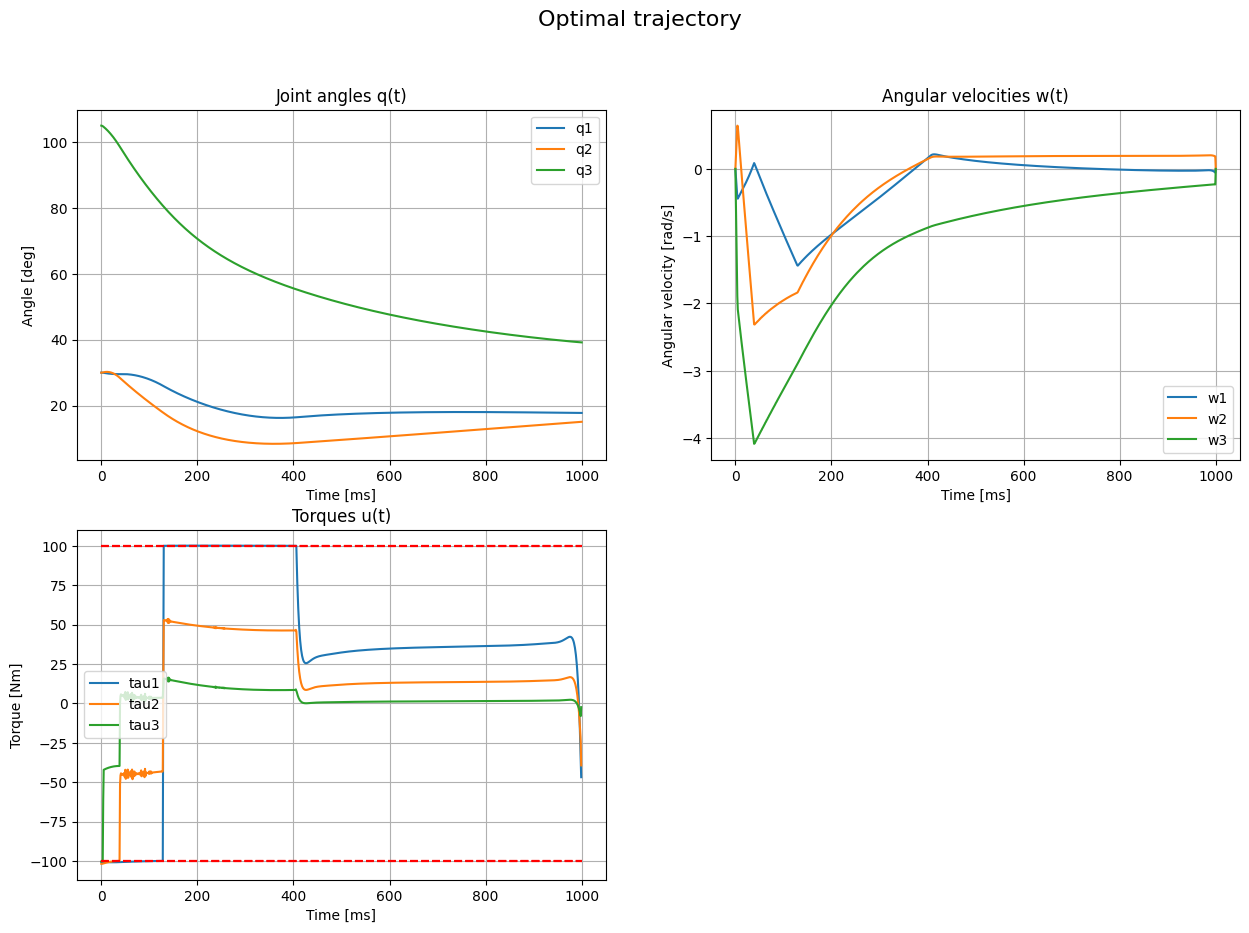

In [223]:
plotOCSolution(xs=log.xs, us=log.us, figTitle="Optimal trajectory")